# 2D Binaural Delay Neuron Echo

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path('..') / 'src'))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig, ObjectsConfig
from transmitter import SpikingRadarTransmitter
from environment import SpikingRadarChannel_2D
from receiver import SpikingRadarReceiverBinaural
from models.spiking_lif_delay import SpikingLIFDelayEstimator
from output import SpikingRadarResult_2D


In [99]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.1,
    spike_prob_per_ms=0.1,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.1,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
    receiver_spacing_m=0.2,
)
objects = ObjectsConfig(object_location_2D=(5.0, 2.0))

tau_ms = 5 / model_config.fs_hz

transmitter = SpikingRadarTransmitter(model_config)
environment = SpikingRadarChannel_2D(model_config, physics_config, objects)
receiver = SpikingRadarReceiverBinaural(model_config)
processing_model = SpikingLIFDelayEstimator(
    model_config,
    physics_config,
    max_delay_s=0.1,
    tau_m_s=tau_ms,
    w_tx=1.0,
    w_rx=1.0,
    v_th=1.5,
)


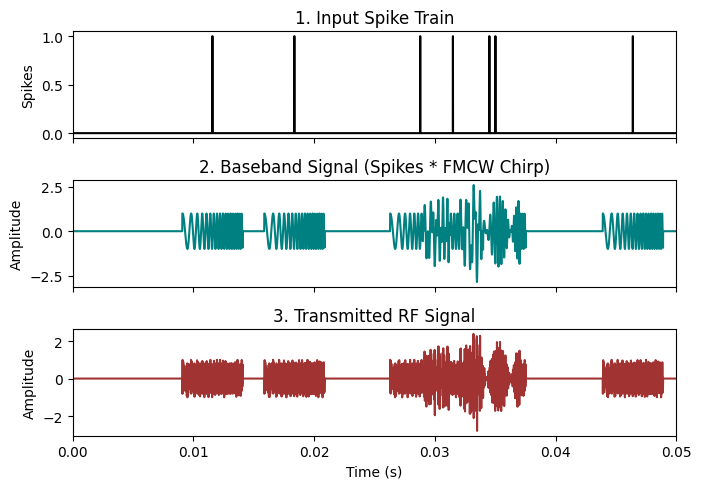

(<Figure size 700x500 with 3 Axes>,
 array([<Axes: title={'center': '1. Input Spike Train'}, ylabel='Spikes'>,
        <Axes: title={'center': '2. Baseband Signal (Spikes * FMCW Chirp)'}, ylabel='Amplitude'>,
        <Axes: title={'center': '3. Transmitted RF Signal'}, xlabel='Time (s)', ylabel='Amplitude'>],
       dtype=object))

In [100]:
# Transmitter

tx = transmitter.build()
transmitter.plot(tx)


In [101]:
# Environment

rx_left, rx_right = environment.propagate(tx.tx_signal)


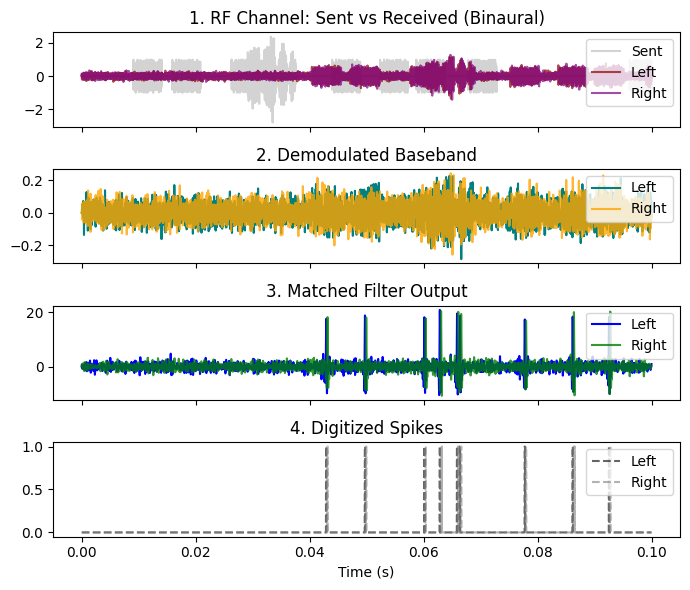

(<Figure size 700x600 with 4 Axes>,
 array([<Axes: title={'center': '1. RF Channel: Sent vs Received (Binaural)'}>,
        <Axes: title={'center': '2. Demodulated Baseband'}>,
        <Axes: title={'center': '3. Matched Filter Output'}>,
        <Axes: title={'center': '4. Digitized Spikes'}, xlabel='Time (s)'>],
       dtype=object))

In [102]:
# Receiver

rx = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)
receiver.plot(tx.time_s, tx.tx_signal, rx)


Text(0.5, 1.0, 'Recovered spikes fed to SNN (Binaural)')

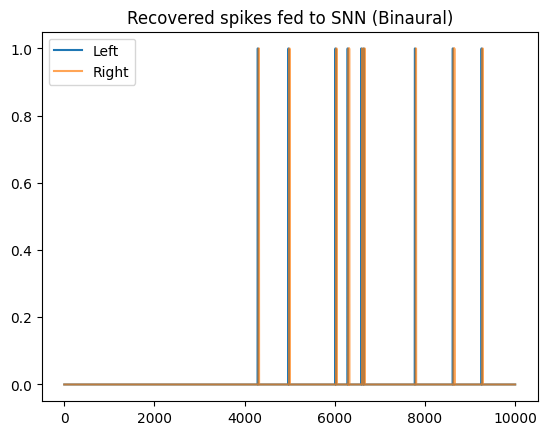

In [87]:
plt.plot(rx.recovered_spikes_left, label="Left")
plt.plot(rx.recovered_spikes_right, label="Right", alpha=0.7)
plt.legend()
plt.title("Recovered spikes fed to SNN (Binaural)")


LIFDelay2DResult(delay_samples_left=3131, delay_samples_right=3153, delay_s_left=0.03131, delay_s_right=0.03153, delay_s=0.031420000000000003, distance_m=5.38853, itd_samples=22, itd_s=0.00022, angle_rad=0.38687907883057593, angle_deg=22.166538398901075, spike_counts_left=array([0, 0, 0, ..., 0, 0, 0]), spike_counts_right=array([0, 0, 0, ..., 0, 0, 0]), spike_counts_itd=array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  6,  5,
        4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  6, 15, 24, 33, 42, 51, 60, 69, 75, 67, 58, 49, 40,
       31, 22, 14,  7,  4,  4,  4,  4,  4,  4,  4,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), delays_s=array([0.000e+00, 1.000e-05, 2.000e-05, ..., 9.998e-02, 9.999e-02,
       1.000e-01]), itd_delays_s

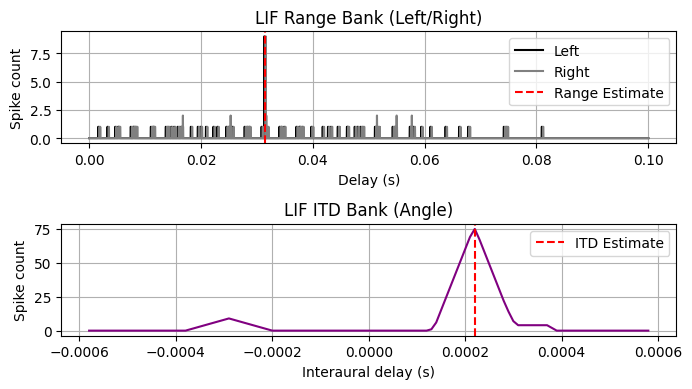

In [105]:
# Processing unit

result = processing_model.estimate_2d(
    tx.spikes,
    rx.recovered_spikes_left,
    rx.recovered_spikes_right,
    receiver_spacing_m=model_config.receiver_spacing_m,
)
print(result)

processing_model.plot_2d(result)

distance_est = result.distance_m
delay_s = result.delay_s
angle_deg = result.angle_deg
itd_s = result.itd_s


In [89]:
# Output

results = SpikingRadarResult_2D(
    distance_m=distance_est,
    delay_s=delay_s,
    angle_deg=angle_deg,
    itd_s=itd_s,
    tx=tx,
    rx=rx,
    objects=objects,
)

results.print_results()

--- RESULTS (2D) ---
Actual Object Location:  (5.00, 2.00) m
Estimated Distance:      5.389 m
Estimated Angle:         22.17 deg
Estimated ITD:           220.0 us


Distance RMSE: 0.004 m
Angle RMSE:    0.341 deg


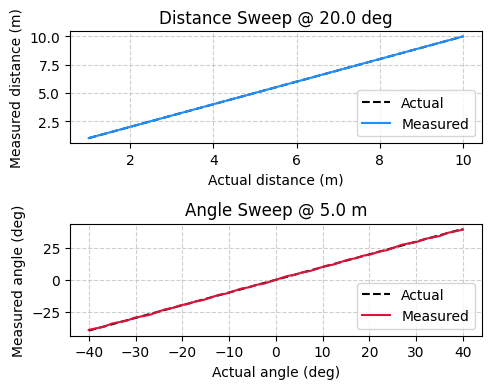

In [106]:
# Sweep distance at fixed angle, then sweep angle at fixed distance

angle_deg_fixed = 20.0
distances = np.linspace(1.0, 10.0, 50)
distances_measured = []

for d in distances:
    obj_x = d * np.cos(np.deg2rad(angle_deg_fixed))
    obj_y = d * np.sin(np.deg2rad(angle_deg_fixed))
    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))
    environment = SpikingRadarChannel_2D(model_config, physics_config, objects_loop)

    rx_left, rx_right = environment.propagate(tx.tx_signal)
    rx_loop = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)

    result = processing_model.estimate_2d(
        tx.spikes,
        rx_loop.recovered_spikes_left,
        rx_loop.recovered_spikes_right,
        receiver_spacing_m=model_config.receiver_spacing_m,
    )
    distances_measured.append(result.distance_m)

distance_fixed = 5.0
angles_deg = np.linspace(-40.0, 40.0, 50)
angles_measured = []

for a in angles_deg:
    obj_x = distance_fixed * np.cos(np.deg2rad(a))
    obj_y = distance_fixed * np.sin(np.deg2rad(a))
    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))
    environment = SpikingRadarChannel_2D(model_config, physics_config, objects_loop)

    rx_left, rx_right = environment.propagate(tx.tx_signal)
    rx_loop = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)

    result = processing_model.estimate_2d(
        tx.spikes,
        rx_loop.recovered_spikes_left,
        rx_loop.recovered_spikes_right,
        receiver_spacing_m=model_config.receiver_spacing_m,
    )
    angles_measured.append(result.angle_deg)

distances_measured = np.array(distances_measured)
angles_measured = np.array(angles_measured)

dist_rmse = np.sqrt(np.mean((distances_measured - distances) ** 2))
angle_rmse = np.sqrt(np.mean((angles_measured - angles_deg) ** 2))

print(f"Distance RMSE: {dist_rmse:.3f} m")
print(f"Angle RMSE:    {angle_rmse:.3f} deg")

fig, axes = plt.subplots(2, 1, figsize=(5, 4))

axes[0].plot(distances, distances, label="Actual", color="black", linestyle="--")
axes[0].plot(distances, distances_measured, label="Measured", color="dodgerblue")
axes[0].set_title(f"Distance Sweep @ {angle_deg_fixed:.1f} deg")
axes[0].set_xlabel("Actual distance (m)")
axes[0].set_ylabel("Measured distance (m)")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(loc="lower right")

axes[1].plot(angles_deg, angles_deg, label="Actual", color="black", linestyle="--")
axes[1].plot(angles_deg, angles_measured, label="Measured", color="crimson")
axes[1].set_title(f"Angle Sweep @ {distance_fixed:.1f} m")
axes[1].set_xlabel("Actual angle (deg)")
axes[1].set_ylabel("Measured angle (deg)")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


For your current ITD‑based angle estimate:

ITD bin size (time resolution):
Δt = 1 / fs_hz

Angle from ITD:
θ = asin( (c * ITD) / receiver_spacing_m )

Local angular resolution (small change):
Δθ ≈ (c / (receiver_spacing_m * cos θ)) * Δt (radians)

So at small angles (cos θ ≈ 1):
Δθ ≈ c / (receiver_spacing_m * fs_hz) (radians)
Δθ_deg ≈ (180/π) * c / (receiver_spacing_m * fs_hz) (degrees)

If you also want the range resolution from sampling:
ΔR ≈ c / (2 * fs_hz) (meters)

Using your current values (fs_hz=100_000, receiver_spacing_m=0.2, c=343 m/s):

ITD bin size: Δt = 1/fs = 10 µs
Angle resolution (small angles):
(0.2*100000) = 0.01715 rad ≈ 0.98°
At 40° off‑axis:
 cos(40°) ≈ 1.28°
Range resolution:
(200000) = 0.001715 m ≈ 1.7 mm
If your receiver_spacing_m or fs_hz differs, tell me the values and I’ll recompute.

In [ ]:
# LIF range bank raster (left channel)
spike_counts_left, spike_times_left = processing_model.run_lif_bank_raster(
    tx.spikes,
    rx.recovered_spikes_left,
)

spike_t = []
spike_i = []
for i, times in enumerate(spike_times_left):
    if times:
        spike_t.extend(np.array(times) / model_config.fs_hz)
        spike_i.extend([i] * len(times))

plt.figure(figsize=(10, 6))
plt.scatter(spike_t, spike_i, s=2, color="black")
plt.xlabel("Time (s)")
plt.ylabel("Delay neuron index")
plt.title("LIF Range Bank Raster (Left)")
plt.grid(True, alpha=0.3)
plt.show()
